In [1]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, IterableDataset
import torch.nn.functional as F
import chess
from tqdm import tqdm
import glob

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [2]:
MODEL_NUMBER = 2
MODEL_VERSION = 3

In [3]:
class EvalNet(nn.Module):
    """
    Neural network model for evaluating chess positions.

    This model takes a chess position as input and predicts the evaluation score
    for that position. It consists of convolutional and fully connected layers.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer.
        conv2 (nn.Conv2d): Second convolutional layer.
        fc1 (nn.Linear): First fully connected layer.
        fc2 (nn.Linear): Second fully connected layer.

    Methods:
        forward(x): Performs forward pass through the network.
    """

    def __init__(self) -> None:
        """
        Initializes the EvalNet class

        Args:
        - None

        Returns:
        - None
        """
        super(EvalNet, self).__init__()
        self.conv1 = nn.Conv2d(12, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1536, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass through the network.

        Args:
        - x (torch.Tensor): Input tensor of shape (batch_size, 12, 8, 8)
        
        Returns:
        - torch.Tensor: Output tensor of shape (batch_size, 1)
        """
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.fc1(x))
        return self.fc2(x)  

In [4]:
def fen_str_to_3d_tensor(fen: str) -> torch.Tensor:
    """
    Converts a FEN string representation of a chess position to a 3D tensor.

    Args:
    - fen (str): The FEN string representing the chess position.

    Returns:
    - torch.Tensor: A 3D tensor representing the chess position, where each element
                    corresponds to a piece on the board.

    Example:
        fen = 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
        tensor = fen_str_to_3d_tensor(fen)
    """
    piece_to_int = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11,
    }

    board = np.zeros((12, 8, 8), dtype=np.float32)
    
    # Split the FEN string into parts ## 'rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1'
    fen_parts = fen.split(' ')
    fen_rows = fen_parts[0].split('/') # Only process the board position (the first part)
    
    for row_idx, row in enumerate(fen_rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                col_idx += int(char)
            else:
                piece = piece_to_int[char]
                board[piece, row_idx, col_idx] = 1
                col_idx += 1
    
    return torch.tensor(board)

In [5]:
path = "../Data/DataTrain"

letters_in = 'bcdefghijklmnopqrstuvwxyz'
letters_out = 'a'

csv_files_train = []
csv_files_val = []

for let in letters_in:
    csv_files_train.extend(glob.glob(f'{path}/Chess_Jan_{let}*'))
    csv_files_train.extend(glob.glob(f'{path}/Chess_Feb_{let}*'))
    csv_files_train.extend(glob.glob(f'{path}/Chess_Mar_{let}*')) # include in version 1-3
    # csv_files_train.extend(glob.glob(f'{path}/Chess_Apr_{let}*'))

for let_ in letters_out:
    csv_files_val.extend(glob.glob(f'{path}/Chess_Jan_{let_}*'))
    csv_files_val.extend(glob.glob(f'{path}/Chess_Feb_{let_}*'))
    csv_files_val.extend(glob.glob(f'{path}/Chess_Mar_{let_}*')) # include in version 1-3
    # csv_files_val.extend(glob.glob(f'{path}/Chess_Apr_{let_}*'))

In [6]:
def preprocess_inputs(DF: pl.DataFrame) -> torch.Tensor:
    """
    Proprocesses the input tensor into batches by applying the fen_str_to_3d_tensor function.
    """
    
    n_rows = DF.shape[0]

    inputs = torch.zeros(n_rows, 12, 8, 8)

    for i in range(n_rows):
        inputs[i] = fen_str_to_3d_tensor(DF['board'][i])
    
    return inputs

In [7]:
def Data(csv_file):
    
    df = pl.read_csv(csv_file, null_values=["None", "null", "#0", "#-0"])
    df = df.drop_nulls()

    df = df.with_columns(clip=pl.col("cp").clip(-10, 10))

    inputs = preprocess_inputs(df)
    targets = torch.tensor(df['cp'])

    return inputs, targets



class ChessIterableDataset(IterableDataset):
    def __init__(self, csv_files, chunksize=50000):
        """
        Initializes the ChessIterableDataset class.

        Args:
        - csv_files (list): List of CSV file paths.

        Returns:
        - None
        """
        self.csv_files = csv_files
        self.chunksize = chunksize

        
    def __len__(self):
        """
        Implements the length method.

        Returns:
        - int: Length of the dataset.
        """
        return sum(1 for _ in self.__iter__())


    def __iter__(self):
        """
        Implements the iterator logic.

        Returns:
        - Iterator object
        """
        return iter(self.csv_files)

In [8]:
def train(model, csv_files_train, csv_files_val, criterion, optimizer, num_epochs):
    """
    Trains model

    Parameters
    ----------
    model : torch.nn.Module
        model to be trained.
    train_data_loader : torch.utils.data.DataLoader
        training data.
    val_data_loader : torch.utils.data.DataLoader
        validation data.
    criterion : torch.nn.modules.loss._Loss
        loss function
    optimizer : torch.optim.Optimizer
        optimizer
    num_epochs : int
        Number of epochs

    Returns
    -------
    list
        average training loss for each epoch
    list
        average validation loss for each epoch

    """
    print(f'Begin Training! (on {device})')

    training_loss_history = []
    validation_loss_history = []

    try:
        for epoch in tqdm(range(num_epochs)):

            train_running_loss = 0.0
            val_running_loss = 0.0

            ## TRAINING PHASE =================================
            model.train()  # Set the model to training mode

            for i, csv_file in enumerate(csv_files_train):

                inputs, targets = Data(csv_file)

                inputs = inputs.to(device)
                targets = targets.to(device).unsqueeze(1)

                optimizer.zero_grad()
                train_outputs = model(inputs)
                train_batch_loss = criterion(train_outputs, targets)

                print(f"\t Training Batch Loss: {train_batch_loss}")

                train_batch_loss.backward()
                optimizer.step()

                train_running_loss += train_batch_loss.item()
            
            ## VALIDATION PHASE =================================
            model.eval()  # Set the model to evaluation mode
        
            with torch.no_grad():
                for i, csv_file in enumerate(csv_files_val):

                    inputs_val, targets_val = Data(csv_file)

                    inputs_val = inputs_val.to(device)
                    targets_val = targets_val.to(device).unsqueeze(1)
                    
                    val_outputs = model(inputs_val) # forward
                    val_batch_loss = criterion(val_outputs, targets_val)

                    print(f"\t Validation Batch Loss: {val_batch_loss}")

                    val_running_loss += val_batch_loss.item()

            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_running_loss/len(csv_files_train):.5f}, Validation Loss: {val_running_loss/len(csv_files_val):.5f}')
            training_loss_history.append(train_running_loss/len(csv_files_train))
            validation_loss_history.append(val_running_loss/len(csv_files_val))
            
    except KeyboardInterrupt:
        print("Manual Stop: Finished Training Early!")
    finally:
        torch.save(model, f'models_autosave/autosave{MODEL_NUMBER}-{MODEL_VERSION}.pth')

    print(f'Finished Training!')

    return training_loss_history, validation_loss_history

In [9]:
model = EvalNet()
# model = torch.load('models_autosave/autosave2-0.pth')
model = model.to(device)

criterion = nn.L1Loss() # nn.MSELoss()

optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01)

train_loss_hist, valid_loss_hist = train(model, csv_files_train, csv_files_val, criterion, optimizer, num_epochs = 20)

Begin Training! (on cuda)


  0%|          | 0/20 [00:00<?, ?it/s]

	 Training Batch Loss: 3.859437942504883
	 Training Batch Loss: 3.8211560249328613
	 Training Batch Loss: 3.758753538131714
	 Training Batch Loss: 3.9393136501312256
	 Training Batch Loss: 3.8775501251220703
	 Training Batch Loss: 3.796144723892212
	 Training Batch Loss: 3.8363585472106934
	 Training Batch Loss: 3.817406177520752
	 Training Batch Loss: 3.937455415725708
	 Training Batch Loss: 3.9240968227386475
	 Training Batch Loss: 3.7842390537261963
	 Training Batch Loss: 3.9083123207092285
	 Training Batch Loss: 3.875164031982422
	 Training Batch Loss: 3.8071892261505127
	 Training Batch Loss: 3.8439998626708984
	 Training Batch Loss: 3.8476057052612305
	 Training Batch Loss: 3.9741337299346924
	 Training Batch Loss: 4.018704414367676
	 Training Batch Loss: 3.91023850440979
	 Training Batch Loss: 3.9282455444335938
	 Training Batch Loss: 3.802035093307495
	 Training Batch Loss: 3.9043967723846436
	 Training Batch Loss: 3.797558307647705
	 Training Batch Loss: 3.7230374813079834
	 T

  5%|▌         | 1/20 [3:04:41<58:29:15, 11081.86s/it]

	 Validation Batch Loss: 3.577392101287842
Epoch 1/20, Training Loss: 3.73311, Validation Loss: 3.39519
	 Training Batch Loss: 3.2871575355529785
	 Training Batch Loss: 3.5545637607574463
	 Training Batch Loss: 3.215606927871704
	 Training Batch Loss: 3.3807473182678223
	 Training Batch Loss: 3.286332130432129
	 Training Batch Loss: 3.373335123062134
	 Training Batch Loss: 3.351947546005249
	 Training Batch Loss: 3.3187754154205322
	 Training Batch Loss: 3.3303773403167725
	 Training Batch Loss: 3.3710148334503174
	 Training Batch Loss: 3.2005693912506104
	 Training Batch Loss: 3.3053042888641357
	 Training Batch Loss: 3.2841553688049316
	 Training Batch Loss: 3.1982064247131348
	 Training Batch Loss: 3.1832756996154785
	 Training Batch Loss: 3.167020320892334
	 Training Batch Loss: 3.17740797996521
	 Training Batch Loss: 3.183011770248413
	 Training Batch Loss: 3.143542766571045
	 Training Batch Loss: 3.1298258304595947
	 Training Batch Loss: 3.005523681640625
	 Training Batch Loss: 3

 10%|█         | 2/20 [6:22:04<57:38:47, 11529.31s/it]

	 Validation Batch Loss: 3.7048702239990234
Epoch 2/20, Training Loss: 3.25943, Validation Loss: 3.50663
	 Training Batch Loss: 3.402407169342041
	 Training Batch Loss: 3.5666162967681885
	 Training Batch Loss: 3.491197347640991
	 Training Batch Loss: 3.4574992656707764
	 Training Batch Loss: 3.488722324371338
	 Training Batch Loss: 3.5213584899902344
	 Training Batch Loss: 3.3117783069610596
	 Training Batch Loss: 3.4187889099121094
	 Training Batch Loss: 3.4973442554473877
	 Training Batch Loss: 3.3017265796661377
	 Training Batch Loss: 3.336351156234741
	 Training Batch Loss: 3.3759894371032715
	 Training Batch Loss: 3.289045572280884
	 Training Batch Loss: 3.2755208015441895
	 Training Batch Loss: 3.2395780086517334
	 Training Batch Loss: 3.221487522125244
	 Training Batch Loss: 3.240086317062378
	 Training Batch Loss: 3.2760815620422363
	 Training Batch Loss: 3.2190146446228027
	 Training Batch Loss: 3.1775307655334473
	 Training Batch Loss: 3.0879971981048584
	 Training Batch Los

 15%|█▌        | 3/20 [9:40:03<55:11:55, 11689.14s/it]

	 Validation Batch Loss: 3.404419183731079
Epoch 3/20, Training Loss: 2.90622, Validation Loss: 3.19592
	 Training Batch Loss: 3.089094400405884
	 Training Batch Loss: 3.0577290058135986
	 Training Batch Loss: 2.9524617195129395
	 Training Batch Loss: 3.005950450897217
	 Training Batch Loss: 2.920186996459961
	 Training Batch Loss: 2.878117561340332
	 Training Batch Loss: 2.766364574432373
	 Training Batch Loss: 2.774008274078369
	 Training Batch Loss: 2.825157642364502
	 Training Batch Loss: 2.789611339569092
	 Training Batch Loss: 2.733306646347046
	 Training Batch Loss: 2.7380263805389404
	 Training Batch Loss: 2.680908203125
	 Training Batch Loss: 2.727851152420044
	 Training Batch Loss: 2.7717928886413574
	 Training Batch Loss: 2.719269037246704
	 Training Batch Loss: 2.659288167953491
	 Training Batch Loss: 2.7516236305236816
	 Training Batch Loss: 2.720344305038452
	 Training Batch Loss: 2.6577086448669434
	 Training Batch Loss: 2.6230602264404297
	 Training Batch Loss: 2.755882

 20%|██        | 4/20 [12:57:53<52:16:07, 11760.47s/it]

	 Validation Batch Loss: 2.6294193267822266
Epoch 4/20, Training Loss: 2.80849, Validation Loss: 2.52886
	 Training Batch Loss: 2.4346916675567627
	 Training Batch Loss: 2.546952247619629
	 Training Batch Loss: 2.7061984539031982
	 Training Batch Loss: 2.5477993488311768
	 Training Batch Loss: 2.5909597873687744
	 Training Batch Loss: 2.637159585952759
	 Training Batch Loss: 2.462618589401245
	 Training Batch Loss: 2.7391440868377686
	 Training Batch Loss: 2.559321403503418
	 Training Batch Loss: 2.8197970390319824
	 Training Batch Loss: 2.662449836730957
	 Training Batch Loss: 2.526447296142578
	 Training Batch Loss: 2.61759614944458
	 Training Batch Loss: 2.5985310077667236
	 Training Batch Loss: 2.499962329864502
	 Training Batch Loss: 2.6093485355377197
	 Training Batch Loss: 2.669797420501709
	 Training Batch Loss: 2.5272581577301025
	 Training Batch Loss: 2.623615264892578
	 Training Batch Loss: 2.5916006565093994
	 Training Batch Loss: 2.4742538928985596
	 Training Batch Loss: 2

 25%|██▌       | 5/20 [16:15:46<49:10:15, 11801.04s/it]

	 Validation Batch Loss: 2.8802430629730225
Epoch 5/20, Training Loss: 2.71229, Validation Loss: 2.74458
	 Training Batch Loss: 2.6362993717193604
	 Training Batch Loss: 2.5637824535369873
	 Training Batch Loss: 2.776261568069458
	 Training Batch Loss: 2.634925603866577
	 Training Batch Loss: 2.6549324989318848
	 Training Batch Loss: 2.60262393951416
	 Training Batch Loss: 2.41726016998291
	 Training Batch Loss: 2.5934360027313232
	 Training Batch Loss: 2.5042521953582764
	 Training Batch Loss: 2.633382558822632
	 Training Batch Loss: 2.4748756885528564
	 Training Batch Loss: 2.600292205810547
	 Training Batch Loss: 2.504430055618286
	 Training Batch Loss: 2.511601686477661
	 Training Batch Loss: 2.80851674079895
	 Training Batch Loss: 2.946286678314209
	 Training Batch Loss: 2.6081321239471436
	 Training Batch Loss: 3.0038414001464844
	 Training Batch Loss: 2.7907845973968506
	 Training Batch Loss: 2.7931294441223145
	 Training Batch Loss: 2.649775266647339
	 Training Batch Loss: 2.73

 30%|███       | 6/20 [19:33:42<45:59:32, 11826.61s/it]

	 Validation Batch Loss: 2.5127835273742676
Epoch 6/20, Training Loss: 2.58808, Validation Loss: 2.39568
	 Training Batch Loss: 2.288358688354492
	 Training Batch Loss: 2.4380736351013184
	 Training Batch Loss: 2.3765487670898438
	 Training Batch Loss: 2.5148532390594482
	 Training Batch Loss: 2.4635050296783447
	 Training Batch Loss: 2.418351650238037
	 Training Batch Loss: 2.4016165733337402
	 Training Batch Loss: 2.383532762527466
	 Training Batch Loss: 2.4868600368499756
	 Training Batch Loss: 2.5971007347106934
	 Training Batch Loss: 2.3843860626220703
	 Training Batch Loss: 2.416874647140503
	 Training Batch Loss: 2.4281482696533203
	 Training Batch Loss: 2.3906471729278564
	 Training Batch Loss: 2.386843681335449
	 Training Batch Loss: 2.3574411869049072
	 Training Batch Loss: 2.4573814868927
	 Training Batch Loss: 2.4257633686065674
	 Training Batch Loss: 2.4306392669677734
	 Training Batch Loss: 2.414151668548584
	 Training Batch Loss: 2.306041955947876
	 Training Batch Loss: 

 35%|███▌      | 7/20 [22:51:33<42:45:31, 11840.90s/it]

	 Validation Batch Loss: 2.6264808177948
Epoch 7/20, Training Loss: 2.57587, Validation Loss: 2.50927
	 Training Batch Loss: 2.422523260116577
	 Training Batch Loss: 2.3854103088378906
	 Training Batch Loss: 2.4496378898620605
	 Training Batch Loss: 2.5381226539611816
	 Training Batch Loss: 2.4685606956481934
	 Training Batch Loss: 2.42887544631958
	 Training Batch Loss: 2.4294650554656982
	 Training Batch Loss: 2.435169219970703
	 Training Batch Loss: 2.4535019397735596
	 Training Batch Loss: 2.5637009143829346
	 Training Batch Loss: 2.4431114196777344
	 Training Batch Loss: 2.417273998260498
	 Training Batch Loss: 2.4291574954986572
	 Training Batch Loss: 2.430556297302246
	 Training Batch Loss: 2.414583683013916
	 Training Batch Loss: 2.3767402172088623
	 Training Batch Loss: 2.4459311962127686
	 Training Batch Loss: 2.4370059967041016
	 Training Batch Loss: 2.442852258682251
	 Training Batch Loss: 2.4443089962005615
	 Training Batch Loss: 2.3226535320281982
	 Training Batch Loss: 2

 40%|████      | 8/20 [26:09:14<39:29:28, 11847.40s/it]

	 Validation Batch Loss: 2.5506210327148438
Epoch 8/20, Training Loss: 2.50373, Validation Loss: 2.45277
	 Training Batch Loss: 2.3669981956481934
	 Training Batch Loss: 2.314617395401001
	 Training Batch Loss: 2.2601065635681152
	 Training Batch Loss: 2.4420831203460693
	 Training Batch Loss: 2.36613130569458
	 Training Batch Loss: 2.351687431335449
	 Training Batch Loss: 2.3124256134033203
	 Training Batch Loss: 2.304933786392212
	 Training Batch Loss: 2.3928794860839844
	 Training Batch Loss: 2.5055317878723145
	 Training Batch Loss: 2.3829362392425537
	 Training Batch Loss: 2.3481109142303467
	 Training Batch Loss: 2.340214252471924
	 Training Batch Loss: 2.395894765853882
	 Training Batch Loss: 2.348928928375244
	 Training Batch Loss: 2.33469820022583
	 Training Batch Loss: 2.4143195152282715
	 Training Batch Loss: 2.3318047523498535
	 Training Batch Loss: 2.347120523452759
	 Training Batch Loss: 2.3542122840881348
	 Training Batch Loss: 2.274724245071411
	 Training Batch Loss: 2.

 45%|████▌     | 9/20 [29:26:48<36:12:25, 11849.62s/it]

	 Validation Batch Loss: 2.72994065284729
Epoch 9/20, Training Loss: 2.49488, Validation Loss: 2.60239
	 Training Batch Loss: 2.500863790512085
	 Training Batch Loss: 2.5005223751068115
	 Training Batch Loss: 2.4581480026245117
	 Training Batch Loss: 2.5390830039978027
	 Training Batch Loss: 2.545562505722046
	 Training Batch Loss: 2.452759265899658
	 Training Batch Loss: 2.424097776412964
	 Training Batch Loss: 2.498908758163452
	 Training Batch Loss: 2.4726133346557617
	 Training Batch Loss: 2.4948458671569824
	 Training Batch Loss: 2.4531590938568115
	 Training Batch Loss: 2.4461188316345215
	 Training Batch Loss: 2.4560301303863525
	 Training Batch Loss: 2.478475570678711
	 Training Batch Loss: 2.4619240760803223
	 Training Batch Loss: 2.420088291168213
	 Training Batch Loss: 2.447746515274048
	 Training Batch Loss: 2.4791457653045654
	 Training Batch Loss: 2.4652042388916016
	 Training Batch Loss: 2.436354160308838
	 Training Batch Loss: 2.3384766578674316
	 Training Batch Loss: 2

 50%|█████     | 10/20 [32:44:13<32:54:40, 11848.10s/it]

	 Validation Batch Loss: 2.5162861347198486
Epoch 10/20, Training Loss: 2.46215, Validation Loss: 2.42934
	 Training Batch Loss: 2.349139451980591
	 Training Batch Loss: 2.266899824142456
	 Training Batch Loss: 2.265235424041748
	 Training Batch Loss: 2.403723955154419
	 Training Batch Loss: 2.333972692489624
	 Training Batch Loss: 2.3462963104248047
	 Training Batch Loss: 2.199272871017456
	 Training Batch Loss: 2.3650221824645996
	 Training Batch Loss: 2.519374370574951
	 Training Batch Loss: 2.492323160171509
	 Training Batch Loss: 2.3423850536346436
	 Training Batch Loss: 2.463959217071533
	 Training Batch Loss: 2.3742892742156982
	 Training Batch Loss: 2.421546220779419
	 Training Batch Loss: 2.3188018798828125
	 Training Batch Loss: 2.2945454120635986
	 Training Batch Loss: 2.4289658069610596
	 Training Batch Loss: 2.370239019393921
	 Training Batch Loss: 2.3011534214019775
	 Training Batch Loss: 2.3379976749420166
	 Training Batch Loss: 2.277634382247925
	 Training Batch Loss: 2

 55%|█████▌    | 11/20 [36:04:52<29:45:58, 11906.51s/it]

	 Validation Batch Loss: 2.4562361240386963
Epoch 11/20, Training Loss: 2.41719, Validation Loss: 2.36442
	 Training Batch Loss: 2.284330129623413
	 Training Batch Loss: 2.280564785003662
	 Training Batch Loss: 2.2339980602264404
	 Training Batch Loss: 2.3250434398651123
	 Training Batch Loss: 2.3591482639312744
	 Training Batch Loss: 2.2696359157562256
	 Training Batch Loss: 2.232828140258789
	 Training Batch Loss: 2.3294053077697754
	 Training Batch Loss: 2.286093235015869
	 Training Batch Loss: 2.368515968322754
	 Training Batch Loss: 2.381734609603882
	 Training Batch Loss: 2.3023509979248047
	 Training Batch Loss: 2.2816832065582275
	 Training Batch Loss: 2.2908389568328857
	 Training Batch Loss: 2.323836088180542
	 Training Batch Loss: 2.252809762954712
	 Training Batch Loss: 2.3500869274139404
	 Training Batch Loss: 2.411203384399414
	 Training Batch Loss: 2.2823188304901123
	 Training Batch Loss: 2.3224949836730957
	 Training Batch Loss: 2.2508952617645264
	 Training Batch Loss

 60%|██████    | 12/20 [38:49:03<25:04:08, 11281.09s/it]

	 Validation Batch Loss: 3.0014588832855225
Epoch 12/20, Training Loss: 2.43009, Validation Loss: 2.84101
	 Training Batch Loss: 2.7542529106140137
	 Training Batch Loss: 2.74161696434021
	 Training Batch Loss: 2.6951708793640137
	 Training Batch Loss: 2.6854779720306396
	 Training Batch Loss: 2.7474000453948975
	 Training Batch Loss: 2.652646780014038
	 Training Batch Loss: 2.593613624572754
	 Training Batch Loss: 2.6697263717651367
	 Training Batch Loss: 2.6679420471191406
	 Training Batch Loss: 2.6763293743133545
	 Training Batch Loss: 2.5556106567382812
	 Training Batch Loss: 2.610548973083496
	 Training Batch Loss: 2.5540382862091064
	 Training Batch Loss: 2.552899122238159
	 Training Batch Loss: 2.5332250595092773
	 Training Batch Loss: 2.4683268070220947
	 Training Batch Loss: 2.5702576637268066
	 Training Batch Loss: 2.553208112716675
	 Training Batch Loss: 2.4837212562561035
	 Training Batch Loss: 2.527461528778076
	 Training Batch Loss: 2.385483741760254
	 Training Batch Loss

 65%|██████▌   | 13/20 [40:48:31<19:30:46, 10035.19s/it]

	 Validation Batch Loss: 2.440784454345703
Epoch 13/20, Training Loss: 2.42418, Validation Loss: 2.36169
	 Training Batch Loss: 2.300271511077881
	 Training Batch Loss: 2.337555170059204
	 Training Batch Loss: 2.2845282554626465
	 Training Batch Loss: 2.3356199264526367
	 Training Batch Loss: 2.439567804336548
	 Training Batch Loss: 2.354440450668335
	 Training Batch Loss: 2.331587791442871
	 Training Batch Loss: 2.2935307025909424
	 Training Batch Loss: 2.380918264389038
	 Training Batch Loss: 2.417207956314087
	 Training Batch Loss: 2.2791850566864014
	 Training Batch Loss: 2.2871382236480713
	 Training Batch Loss: 2.27069091796875
	 Training Batch Loss: 2.292865514755249
	 Training Batch Loss: 2.2890617847442627
	 Training Batch Loss: 2.2534737586975098
	 Training Batch Loss: 2.357635021209717
	 Training Batch Loss: 2.2815778255462646
	 Training Batch Loss: 2.3002166748046875
	 Training Batch Loss: 2.29864764213562
	 Training Batch Loss: 2.2190372943878174
	 Training Batch Loss: 2.2

 70%|███████   | 14/20 [42:49:49<15:20:14, 9202.34s/it] 

	 Validation Batch Loss: 2.4767844676971436
Epoch 14/20, Training Loss: 2.37679, Validation Loss: 2.35828
	 Training Batch Loss: 2.251359462738037
	 Training Batch Loss: 2.3091073036193848
	 Training Batch Loss: 2.3176660537719727
	 Training Batch Loss: 2.4013872146606445
	 Training Batch Loss: 2.278273105621338
	 Training Batch Loss: 2.3899753093719482
	 Training Batch Loss: 2.270002603530884
	 Training Batch Loss: 2.255880355834961
	 Training Batch Loss: 2.333721399307251
	 Training Batch Loss: 2.324000597000122
	 Training Batch Loss: 2.2798140048980713
	 Training Batch Loss: 2.252173900604248
	 Training Batch Loss: 2.2525417804718018
	 Training Batch Loss: 2.286470413208008
	 Training Batch Loss: 2.27890682220459
	 Training Batch Loss: 2.1918272972106934
	 Training Batch Loss: 2.29807186126709
	 Training Batch Loss: 2.2675857543945312
	 Training Batch Loss: 2.265342950820923
	 Training Batch Loss: 2.2763001918792725
	 Training Batch Loss: 2.1731414794921875
	 Training Batch Loss: 2.

 75%|███████▌  | 15/20 [44:51:23<11:58:55, 8627.04s/it]

	 Validation Batch Loss: 3.195275068283081
Epoch 15/20, Training Loss: 2.38622, Validation Loss: 3.05623
	 Training Batch Loss: 2.9487032890319824
	 Training Batch Loss: 2.635117769241333
	 Training Batch Loss: 2.76625919342041
	 Training Batch Loss: 2.750356435775757
	 Training Batch Loss: 2.6644370555877686
	 Training Batch Loss: 2.652462959289551
	 Training Batch Loss: 2.608365058898926
	 Training Batch Loss: 2.58837628364563
	 Training Batch Loss: 2.6183645725250244
	 Training Batch Loss: 2.596268653869629
	 Training Batch Loss: 2.488999128341675
	 Training Batch Loss: 2.5192573070526123
	 Training Batch Loss: 2.5146515369415283
	 Training Batch Loss: 2.501893997192383
	 Training Batch Loss: 2.4720470905303955
	 Training Batch Loss: 2.421001672744751
	 Training Batch Loss: 2.5478806495666504
	 Training Batch Loss: 2.481635093688965
	 Training Batch Loss: 2.4362335205078125
	 Training Batch Loss: 2.484912633895874
	 Training Batch Loss: 2.3985133171081543
	 Training Batch Loss: 2.43

 80%|████████  | 16/20 [46:53:35<9:09:09, 8237.41s/it] 

	 Validation Batch Loss: 2.372600555419922
Epoch 16/20, Training Loss: 2.37122, Validation Loss: 2.28596
	 Training Batch Loss: 2.1995725631713867
	 Training Batch Loss: 2.1863293647766113
	 Training Batch Loss: 2.1894912719726562
	 Training Batch Loss: 2.255586624145508
	 Training Batch Loss: 2.2531654834747314
	 Training Batch Loss: 2.2152609825134277
	 Training Batch Loss: 2.153815984725952
	 Training Batch Loss: 2.21712327003479
	 Training Batch Loss: 2.2354958057403564
	 Training Batch Loss: 2.25394606590271
	 Training Batch Loss: 2.200666904449463
	 Training Batch Loss: 2.2288239002227783
	 Training Batch Loss: 2.225198745727539
	 Training Batch Loss: 2.2292637825012207
	 Training Batch Loss: 2.220405340194702
	 Training Batch Loss: 2.201324462890625
	 Training Batch Loss: 2.309880018234253
	 Training Batch Loss: 2.2530479431152344
	 Training Batch Loss: 2.23467755317688
	 Training Batch Loss: 2.250516414642334
	 Training Batch Loss: 2.1765248775482178
	 Training Batch Loss: 2.25

 85%|████████▌ | 17/20 [48:55:38<6:38:07, 7962.53s/it]

	 Validation Batch Loss: 2.295466661453247
Epoch 17/20, Training Loss: 2.30180, Validation Loss: 2.20759
	 Training Batch Loss: 2.1139817237854004
	 Training Batch Loss: 2.1113905906677246
	 Training Batch Loss: 2.123467445373535
	 Training Batch Loss: 2.2010486125946045
	 Training Batch Loss: 2.1843972206115723
	 Training Batch Loss: 2.160501003265381
	 Training Batch Loss: 2.107295036315918
	 Training Batch Loss: 2.171564817428589
	 Training Batch Loss: 2.18518328666687
	 Training Batch Loss: 2.2168991565704346
	 Training Batch Loss: 2.1403324604034424
	 Training Batch Loss: 2.200336217880249
	 Training Batch Loss: 2.181931972503662
	 Training Batch Loss: 2.1908352375030518
	 Training Batch Loss: 2.1834394931793213
	 Training Batch Loss: 2.2074103355407715
	 Training Batch Loss: 2.2524495124816895
	 Training Batch Loss: 2.218268394470215
	 Training Batch Loss: 2.2599756717681885
	 Training Batch Loss: 2.2323195934295654
	 Training Batch Loss: 2.1567282676696777
	 Training Batch Loss:

 90%|█████████ | 18/20 [50:56:09<4:18:05, 7742.62s/it]

	 Validation Batch Loss: 2.2886428833007812
Epoch 18/20, Training Loss: 2.29989, Validation Loss: 2.20402
	 Training Batch Loss: 2.120203733444214
	 Training Batch Loss: 2.1365342140197754
	 Training Batch Loss: 2.137225866317749
	 Training Batch Loss: 2.2139127254486084
	 Training Batch Loss: 2.2055704593658447
	 Training Batch Loss: 2.185412645339966
	 Training Batch Loss: 2.110581874847412
	 Training Batch Loss: 2.1879444122314453
	 Training Batch Loss: 2.187786102294922
	 Training Batch Loss: 2.2102749347686768
	 Training Batch Loss: 2.150484561920166
	 Training Batch Loss: 2.1986796855926514
	 Training Batch Loss: 2.19769549369812
	 Training Batch Loss: 2.2026731967926025
	 Training Batch Loss: 2.181506633758545
	 Training Batch Loss: 2.1760644912719727
	 Training Batch Loss: 2.2805302143096924
	 Training Batch Loss: 2.2534263134002686
	 Training Batch Loss: 2.2164604663848877
	 Training Batch Loss: 2.218020439147949
	 Training Batch Loss: 2.1678857803344727
	 Training Batch Loss:

 95%|█████████▌| 19/20 [52:57:43<2:06:47, 7607.83s/it]

	 Validation Batch Loss: 2.853025197982788
Epoch 19/20, Training Loss: 2.43048, Validation Loss: 2.76346
	 Training Batch Loss: 2.693614959716797
	 Training Batch Loss: 2.452730178833008
	 Training Batch Loss: 2.4793262481689453
	 Training Batch Loss: 2.577082395553589
	 Training Batch Loss: 2.503096342086792
	 Training Batch Loss: 2.5048255920410156
	 Training Batch Loss: 2.4109790325164795
	 Training Batch Loss: 2.4607086181640625
	 Training Batch Loss: 2.5319268703460693
	 Training Batch Loss: 2.551215648651123
	 Training Batch Loss: 2.427273988723755
	 Training Batch Loss: 2.4721779823303223
	 Training Batch Loss: 2.515664577484131
	 Training Batch Loss: 2.5604238510131836
	 Training Batch Loss: 2.5077412128448486
	 Training Batch Loss: 2.4377589225769043
	 Training Batch Loss: 2.486077070236206
	 Training Batch Loss: 2.555626153945923
	 Training Batch Loss: 2.4687869548797607
	 Training Batch Loss: 2.4870448112487793
	 Training Batch Loss: 2.426070213317871
	 Training Batch Loss: 

100%|██████████| 20/20 [54:59:03<00:00, 9897.20s/it]  

	 Validation Batch Loss: 2.4757485389709473
Epoch 20/20, Training Loss: 2.48372, Validation Loss: 2.38931
Finished Training!


In [10]:
torch.save(model, f'models_3_3/model{MODEL_NUMBER}-{MODEL_VERSION}.pth')

In [11]:
import pickle


with open('pickle/DL_2_3-3_train_loss_history.pkl', 'wb') as f:
    pickle.dump(train_loss_hist, f)

with open('pickle/DL_2_3-3_valid_loss_history.pkl', 'wb') as f:
    pickle.dump(valid_loss_hist, f)

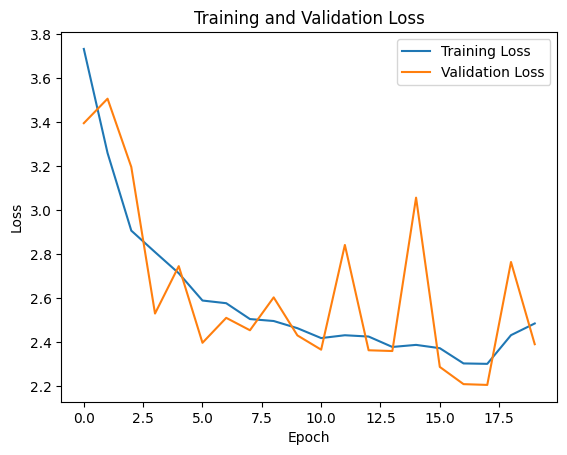

In [12]:
plt.figure()
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(valid_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('figures/DL_2_3-3_loss_history.png')
plt.show()